In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/assets.csv', index_col=0, parse_dates=True)
tickers = list(prices.columns[:-4])+['현금']

In [4]:
oecd = pd.read_csv("data/OECD.csv", index_col=0, parse_dates=True).rename_axis("Date")
oecd_MOM = oecd.resample('D').first().fillna(method='ffill') #전월비
target_weights1 = pd.DataFrame(np.where(oecd_MOM > 1, 1, 0), index=oecd_MOM.index)
target_weights1['현금'] = 1 - target_weights1
target_weights1.columns = ['base1', '현금'] # 'base1'은 위의 전략과 이름을 맞추어야 한다. '현금'도 prices의 컬럼이름과 맞추어야 한다.


kbase1 = bt.Strategy('kbase1',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=1, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights1, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [5]:
외국인수급 = pd.read_csv('data/외국인수급.csv')
외국인수급 = 외국인수급.set_index('Date').T
외국인수급.index = pd.to_datetime(외국인수급.index, format="%Y%m월")
# 외국인수급 = 외국인수급.resample('D').first().fillna(method='ffill')[['유가증권시장']]
# 외국인수급.columns = ['kospi']
외국인수급 = 외국인수급[['유가증권시장']]
외국인수급.columns = ['kospi']
외국인수급['kospi'] = 외국인수급['kospi'].astype('float')
외국인수급 = 외국인수급.shift(1)
외국인수급['1m'] = 외국인수급['kospi'].pct_change(1)
외국인수급['2m'] = 외국인수급['kospi'].pct_change(1).shift(1)
외국인수급['3m'] = 외국인수급['kospi'].pct_change(1).shift(2)
연속3개월 = ((외국인수급['3m'] > 0) & (외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속2개월 = ((외국인수급['2m'] > 0) & (외국인수급['1m'] > 0))
연속1개월 = (외국인수급['1m'] > 0)
target_weights2 = pd.DataFrame(np.where(연속3개월, 1.0,
                                        np.where(연속2개월, 0.66,
                                                np.where(연속1개월, 0.33, 0))),
                             index=외국인수급.index, columns=['base2'])
target_weights2['현금'] = 1.0 - target_weights2
target_weights2.columns = ['base2', '현금']

kbase2 = bt.Strategy(
    'kbase2',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=2, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights2, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [6]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]

c='코스피200'
target_weights3 = pd.DataFrame()
target_weights3['base3'] = prices[c].rolling(365).apply(AMS)
target_weights3['현금'] = 1.0 - target_weights3
target_weights3.columns = ['base3', '현금']

kbase3 = bt.Strategy(
    'kbase3',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.SelectThese(tickers),
        StatIDAverageMomentumScore(lag=pd.DateOffset(days=0), cash='현금'),
        bt.algos.SelectN(n=3, sort_descending=True),
        # bt.algos.PrintDate(),
        WeighEquallyWithoutCash(target_weights3, cash='현금'),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children=tickers,
)

In [7]:
kbase123 = bt.Strategy(
    'kbase123',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        #bt.algos.PrintDate(),
        bt.algos.SelectAll(),
        #bt.algos.SelectThese(tickers),
        bt.algos.WeighEqually(),
        # bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ],
    children = [kbase1, kbase2, kbase3]
)

In [8]:
bt_kbase1 = bt.Backtest(kbase1, prices)
bt_kbase2 = bt.Backtest(kbase2, prices)
bt_kbase3 = bt.Backtest(kbase3, prices)
bt_kbase123 = bt.Backtest(kbase123, prices)

r_all = bt.run(bt_kbase1, bt_kbase2, bt_kbase3, bt_kbase123)

In [9]:
r_all.set_date_range("2002-02-01")
r_all.display()

Stat                 kbase1      kbase2      kbase3      kbase123
-------------------  ----------  ----------  ----------  ----------
Start                2002-02-01  2002-02-01  2002-02-01  2002-02-01
End                  2020-07-02  2020-07-02  2020-07-02  2020-07-02
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         6122.47%    419.82%     892.69%     1490.60%
Daily Sharpe         0.88        0.57        0.67        0.85
Daily Sortino        1.39        0.86        1.02        1.33
CAGR                 25.15%      9.36%       13.27%      16.21%
Max Drawdown         -36.60%     -28.82%     -37.79%     -29.00%
Calmar Ratio         0.69        0.32        0.35        0.56

MTD                  4.87%       1.94%       1.51%       2.77%
3m                   51.31%      10.20%      6.02%       21.63%
6m                   48.79%      11.05%      2.67%       20.10%
YTD                  47.02%      10.94%      2.16%       19.39%
1Y                   55.29%  

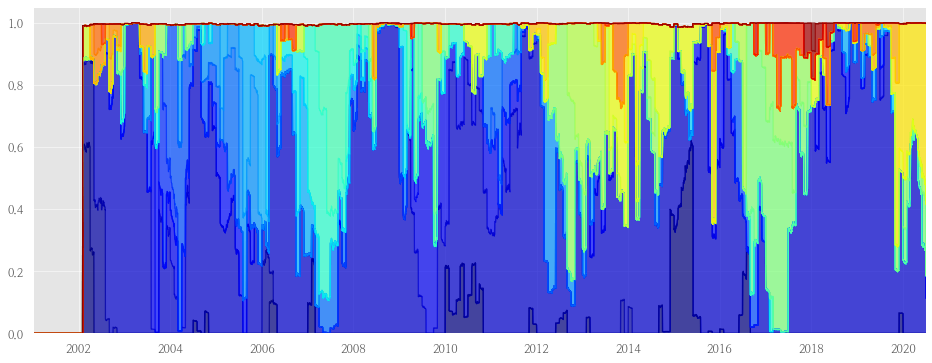

In [10]:
r_all.get_security_weights('kbase123').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

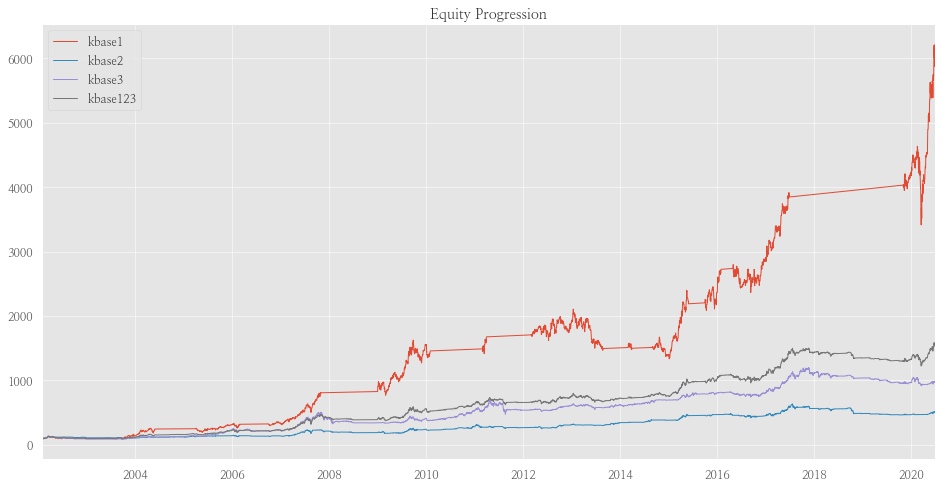

In [11]:
ax = r_all.plot(figsize=(16,8));
plt.legend(loc="upper left");

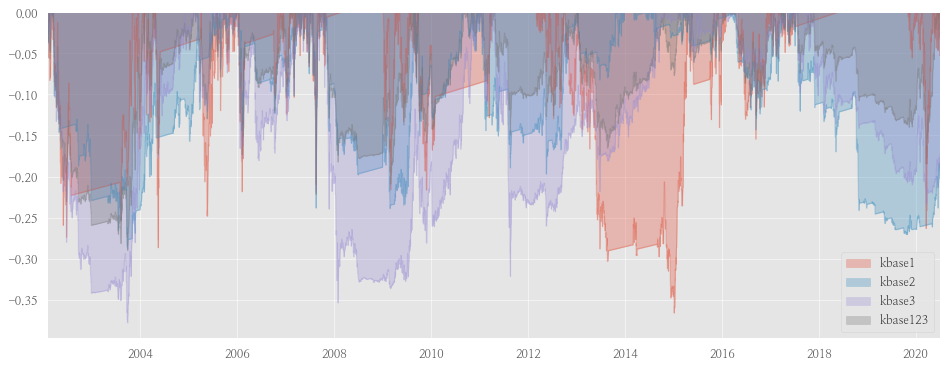

In [12]:
r_all.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

In [13]:
# bt_kbase3.positions.to_csv('한국ID2상대모멘텀_포지션.csv')

                           Strategy
-------------------------  ----------
Start Period               2002-02-02
End Period                 2020-07-02
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          1,490.60%
CAGR﹪                     16.2%

Sharpe                     0.85
Smart Sharpe               0.83
Sortino                    1.26
Smart Sortino              1.23
Sortino/√2                 0.89
Smart Sortino/√2           0.87
Omega                      1.23

Max Drawdown               -29.0%
Longest DD Days            928
Volatility (ann.)          13.3%
Calmar                     0.56
Skew                       0.13
Kurtosis                   11.77

Expected Daily %           0.04%
Expected Monthly %         1.25%
Expected Yearly %          15.68%
Kelly Criterion            13.31%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.33%
Expected Shortfall (cVaR)  -1.33%

Gain/Pain Ratio            0.23
Gain/Pain (1M)           

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2002-03-20,2003-09-29,2004-01-29,680,-28.999,-28.130
2,2007-07-26,2007-08-17,2007-09-06,42,-22.158,-22.158
3,2007-10-30,2009-03-03,2009-07-31,640,-20.905,-19.403
4,2017-11-23,2020-03-19,2020-06-08,928,-18.456,-14.583
5,2013-01-15,2013-06-25,2014-10-22,645,-17.327,-16.198


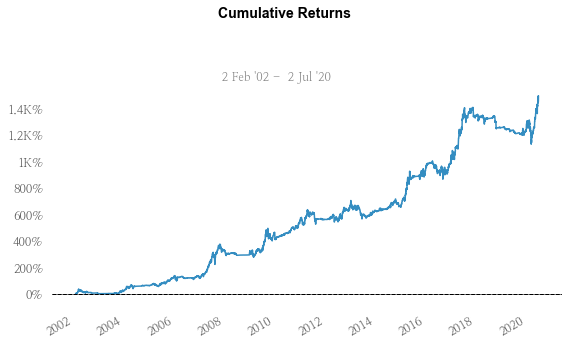

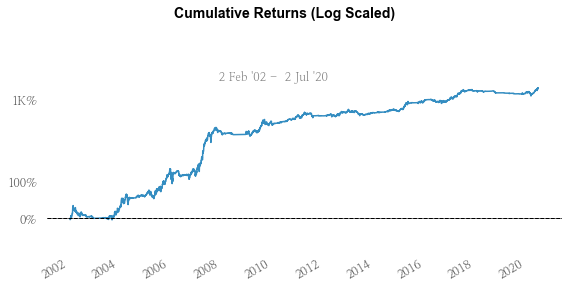

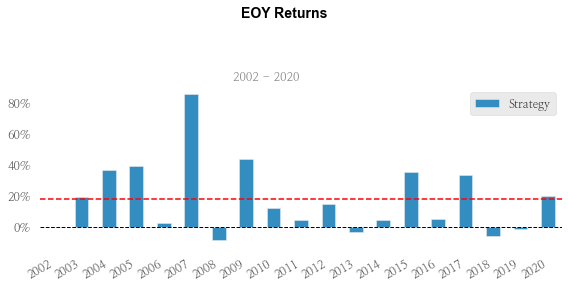

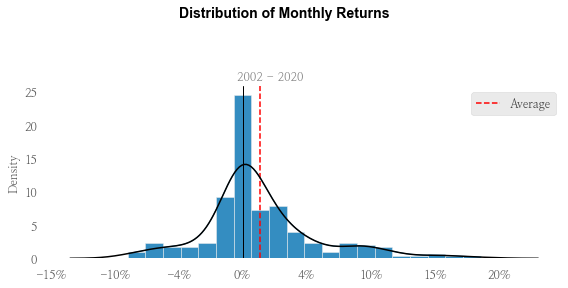

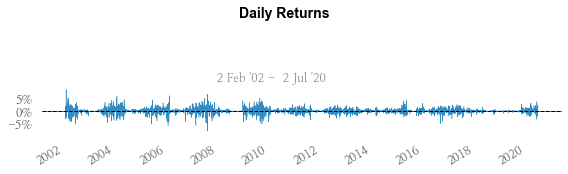

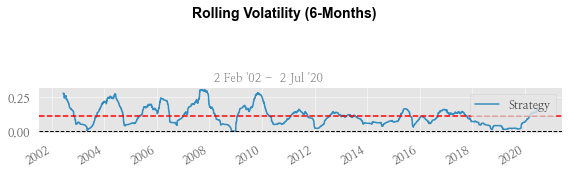

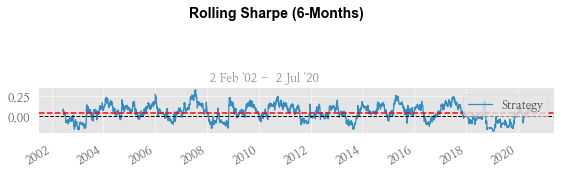

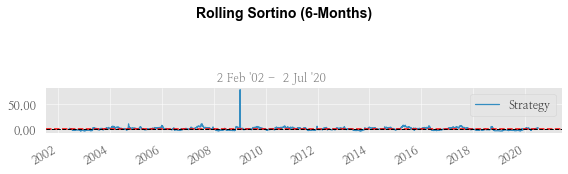

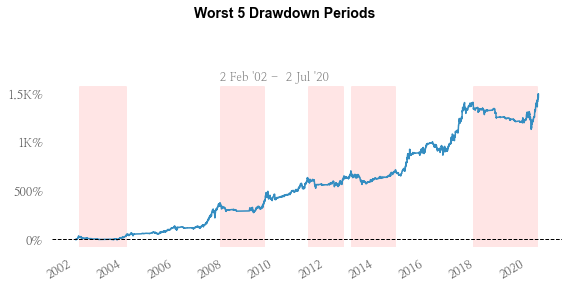

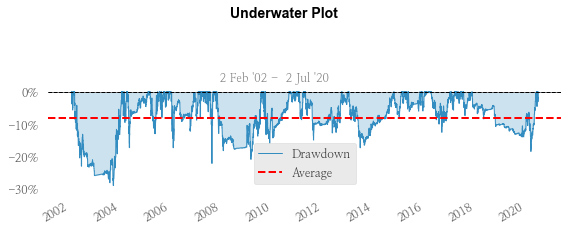

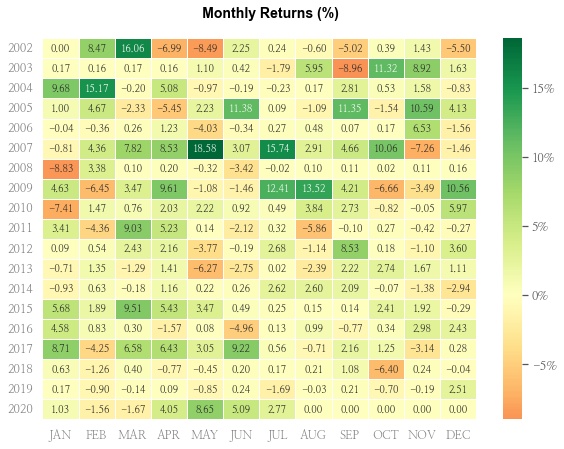

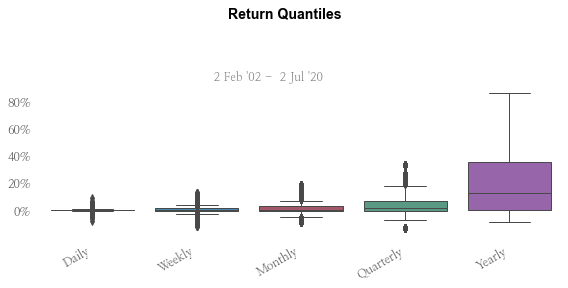

In [14]:
qs.reports.full(r_all['kbase123'].prices.to_returns().dropna())